# Comparison of Outlier Detectors

In this example, we compare the performance of the pyISC Outlier Detector with three outlier detectors from the scikit-learn library (For explanation of the plots, see <a href="http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html">http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html</a>)

Automatically created module for IPython interactive environment


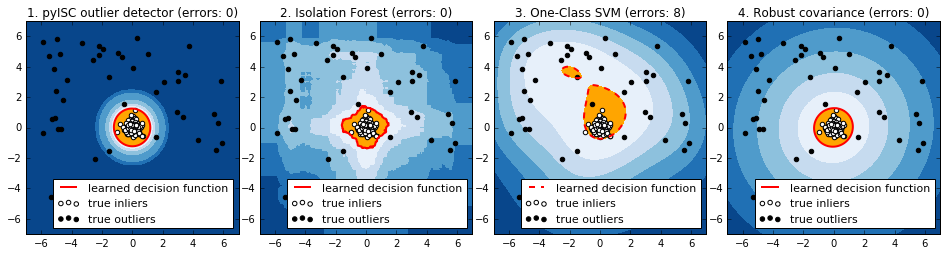

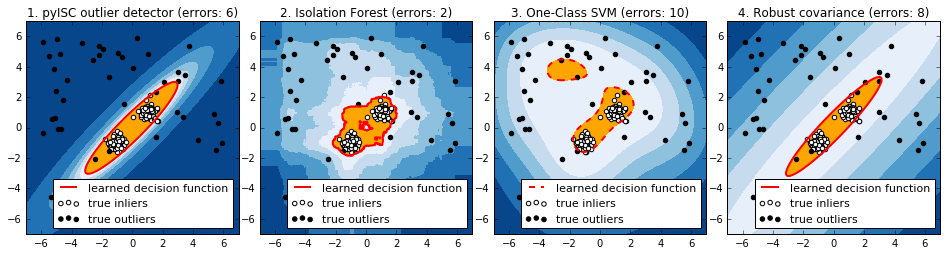

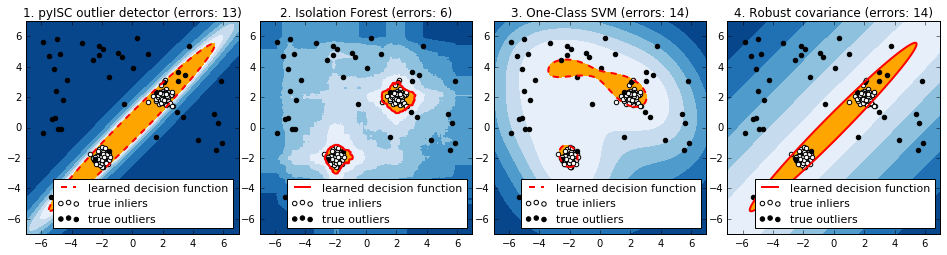

In [1]:
print(__doc__)
%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import pyisc

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define four outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95*outliers_fraction + outliers_fraction/5,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "pyISC outlier detector": pyisc.SklearnOutlierDetector(outliers_fraction,pyisc.P_Gaussian([0,1]),
                                               pyisc.cr_plus)
}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(13.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, len(classifiers), i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11),
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
        
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()

As can be seen above, the result is very similar to the Robust covariance method. Below, we run some tests measuring the run time, where it can be noted that learning is much faster for the pyISC, while it is slower for the Robust covariance method.

In [2]:
%timeit for _ in range(10):classifiers["pyISC outlier detector"].fit(X)

100 loops, best of 3: 16.4 ms per loop


In [3]:
%timeit for _ in range(10):classifiers["Isolation Forest"].fit(X)

1 loop, best of 3: 1.75 s per loop


In [4]:
%timeit for _ in range(10):classifiers["Robust covariance"].fit(X)

1 loop, best of 3: 259 ms per loop


In [5]:
%timeit for _ in range(10):classifiers["One-Class SVM"].fit(X)

100 loops, best of 3: 6.62 ms per loop


In [6]:
%timeit for _ in range(10):classifiers["pyISC outlier detector"].predict(X)

100 loops, best of 3: 2.8 ms per loop


In [7]:
%timeit for _ in range(10):classifiers["Isolation Forest"].predict(X)

1 loop, best of 3: 249 ms per loop


In [8]:
%timeit for _ in range(10):classifiers["Robust covariance"].predict(X)

1000 loops, best of 3: 249 µs per loop


In [9]:
%timeit for _ in range(10):classifiers["One-Class SVM"].predict(X)

100 loops, best of 3: 2.35 ms per loop
